# Ensemble Analysis

This example compares experimental structural data analyzed using Principal Component Analysis (PCA) with the theoretical data predicted by Anisotropic Network Model (ANM):

## Retrieve dataset

In [1]:
from prody import *
from pylab import *
%matplotlib inline

In [2]:
p38 = parsePDB('1p38') # MAP KINASE

@> PDB file is found in working directory (1p38.pdb.gz).
@> 2962 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [3]:
p38_sequence = p38.getHierView()['A'].getSequence()

In [4]:
p38_sequence

'ERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGHRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSLEEFNDVYLVTHLMGADLNNIVKCQKLTDDHVQFLIYQILRGLKYIHSADIIHRDLKPSNLAVNEDCELKILDFGLARHTDDEMTGYVATRWYRAPEIMLNWMHYNQTVDIWSVGCIMAELLTGRTLFPGTDHIDQLKLILRLVGTPGAELLKKISSESARNYIQSLAQMPKMNFANVFIGANPLAVDLLEKMLVLDSDKRITAAQALAHAYFAQYHDPDDEPVADPYDQSFESRDLLIDEWKSLTYDEVISFVPPPLD'

In [5]:
blast_record = blastPDB(p38_sequence)

@> Blast searching NCBI PDB database for "ERPTF..."
@> Blast search completed in 7.4s.


In [6]:
pdbids = blast_record.getHits(percent_identity=90, percent_overlap=70)
len(list(pdbids))

253

In [7]:
pdbfiles = fetchPDB(*pdbids, compressed=False)

## Set reference chain

In [8]:
ref_structure = parsePDB('1p38')
ref_selection = ref_structure.select('resnum 5 to 31 36 to 114 122 to '
                                     '169 185 to 351 and calpha')

@> PDB file is found in working directory (1p38.pdb.gz).
@> 2962 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [9]:
ref_chain = ref_selection.getHierView().getChain('A')
repr(ref_chain)

'<Chain: A from 1p38 (321 residues, 321 atoms)>'

## Ensemble Preparation

We will prepare a **PDBEnsemble** by mapping each structure against the reference chain and adding a coordinates set corresponding to the mapped atoms.

In [10]:
ensemble = PDBEnsemble('p38 X-ray')

In [11]:
ensemble.setAtoms(ref_chain) # Set ensemble atoms
ensemble.setCoords(ref_chain) # Set reference coordinates
# The reference structure is automatically the first member of list provided, which in this case is 1p38.

In [12]:
for pdbfile in pdbfiles:
    structure = parsePDB(pdbfile, subset='calpha')
    if structure is None:
        plog('Failed to parse ' + pdb_file)
        continue
    mappings = mapOntoChain(structure, ref_chain)
    if len(mappings) == 0:
        plog('Failed to map', structure.getTitle()[:4])
        continue
    atommap = mappings[0][0]
    ensemble.addCoordset(atommap, weights=atommap.getFlags('mapped'))

@> 356 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Evaluating AtomGroup 1yqj_ca: 1 chains are identified
@> Trying to map atoms based on residue numbers and identities:
@>   Comparing Chain A from 1yqj_ca (len=356) with Chain A from 1p38:
@> 	Mapped: 321 residues match with 99% sequence identity and 90% overlap.
@> 332 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Evaluating AtomGroup 4e5a_ca: 1 chains are identified
@> Trying to map atoms based on residue numbers and identities:
@>   Comparing Chain X from 4e5a_ca (len=332) with Chain A from 1p38:
@> 	Mapped: 320 residues match with 99% sequence identity and 96% overlap.
@> 349 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Evaluating AtomGroup 2i0h_ca: 1 chains are identified
@> Trying to map atoms based on residue numbers and identities:
@>   Comparing Chain A from 2i0h_ca (len=349) with Chain A from 1p38:
@> 	Mapped: 321 residues match with 99% sequence identity and 91% overlap.
@> 336 atoms and 1 coordi

In [13]:
repr(ensemble)

'<PDBEnsemble: p38 X-ray (262 conformations; 321 atoms)>'

In [14]:
len(ensemble) == len(pdbfiles)

False

In [15]:
ensemble.iterpose()

@> Starting iterative superposition:
@> Step #1: RMSD difference = 8.5323e-01
@> Step #2: RMSD difference = 2.7303e-04
@> Step #3: RMSD difference = 2.2192e-07
@> Iterative superposition completed in 0.29s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.09 seconds.


## PCA calculation

In [16]:
pca = PCA('p38 xray')           # Instantiate a PCA instance

pca.buildCovariance(ensemble)   # Build covariance for the ensemble

pca.calcModes()                 # Calculate modes (20 of the by default)

@> Covariance is calculated using 262 coordinate sets.
@> Covariance matrix calculated in 0.041939s.
@> 20 modes were calculated in 0.08s.


## ANM calculation

In [17]:
anm = ANM('1p38')             # Instantiate a ANM instance

anm.buildHessian(ref_chain)   # Build Hessian for the reference chain

anm.calcModes()               # Calculate slowest non-trivial 20 modes

@> Hessian was built in 0.28s.
@> 20 modes were calculated in 0.08s.


## Save your work

In [18]:
saveModel(pca)
saveModel(anm)
saveEnsemble(ensemble)
writePDB('p38_ref_chain.pdb', ref_chain)

'p38_ref_chain.pdb'

## Fractional Variance

In [19]:
for mode in pca[:3]:    # Print % variance explained by top PCs
    var = calcFractVariance(mode)*100
    print('{0:s}  % variance = {1:.2f}'.format(mode, var))

Mode 1 from PCA p38 xray  % variance = 23.49
Mode 2 from PCA p38 xray  % variance = 17.51
Mode 3 from PCA p38 xray  % variance = 14.73


## Collectivity of modes

In [20]:
for mode in pca[:3]:    # Print PCA mode collectivity
    coll = calcCollectivity(mode)
    print('{0:s}  collectivity = {1:.2f}'.format(mode, coll))

Mode 1 from PCA p38 xray  collectivity = 0.53
Mode 2 from PCA p38 xray  collectivity = 0.17
Mode 3 from PCA p38 xray  collectivity = 0.66


In [21]:
for mode in anm[:3]:    # Print ANM mode collectivity
    coll = calcCollectivity(mode)
    print('{0:s}  collectivity = {1:.2f}'.format(mode, coll))

Mode 1 from ANM 1p38  collectivity = 0.65
Mode 2 from ANM 1p38  collectivity = 0.55
Mode 3 from ANM 1p38  collectivity = 0.68


## PCA - ANM overlap

In [22]:
printOverlapTable(pca[:3], anm[:3]) # Top 3 PCs vs slowest 3 ANM modes

Overlap Table
                        ANM 1p38
                    #1     #2     #3
PCA p38 xray #1   -0.77  +0.05  -0.48
PCA p38 xray #2   +0.19  -0.18  -0.40
PCA p38 xray #3   -0.42  -0.62  +0.41



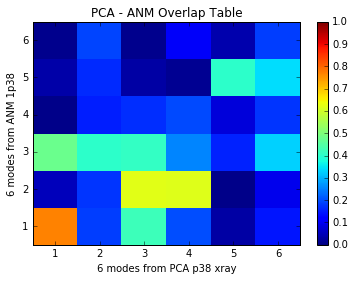

In [23]:
showOverlapTable(pca[:6], anm[:6]);
title('PCA - ANM Overlap Table');

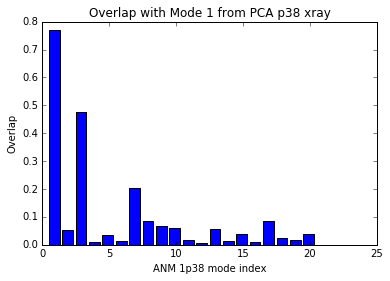

In [24]:
showOverlap(pca[0], anm);

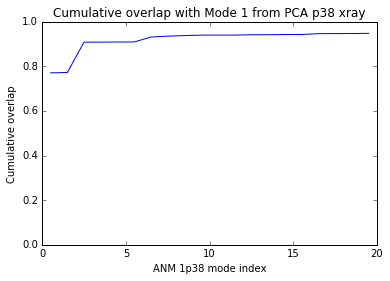

In [25]:
showCumulOverlap(pca[0], anm);

## Square Fluctuations

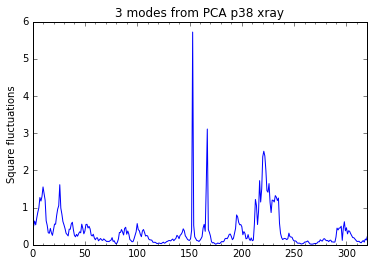

In [26]:
showSqFlucts(pca[:3]);

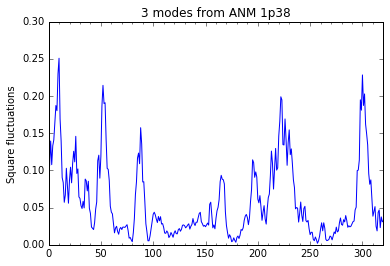

In [27]:
showSqFlucts(anm[:3]);

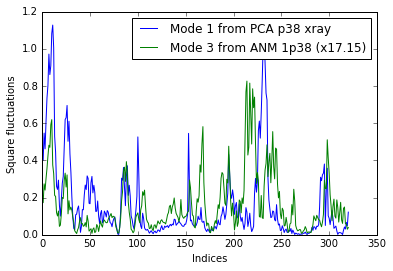

In [28]:
showScaledSqFlucts(pca[0], anm[2]);
legend();

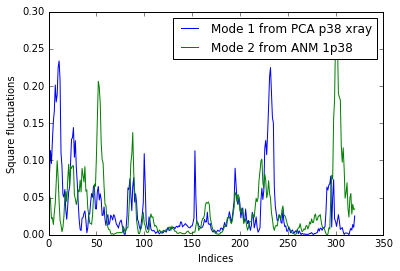

In [29]:
showNormedSqFlucts(pca[0], anm[1]);
legend();

## Cross Correlations

(<matplotlib.image.AxesImage at 0x7f494bafd450>,
 <matplotlib.colorbar.Colorbar at 0x7f494beb81d0>)

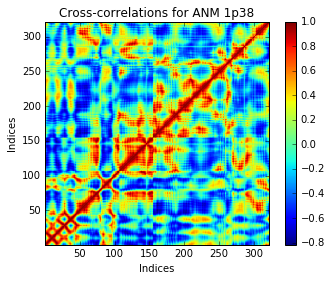

In [30]:
showCrossCorr(anm)

(<matplotlib.image.AxesImage at 0x7f494c16b8d0>,
 <matplotlib.colorbar.Colorbar at 0x7f494bdabf50>)

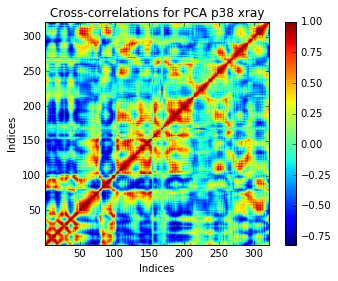

In [31]:
showCrossCorr(pca)

## Preparation of VMD Output

In [32]:
writeNMD('p38_anm.nmd',anm,ref_chain)

'p38_anm.nmd'

In [33]:
writeNMD('p38_pca.nmd',pca,ref_chain)

'p38_pca.nmd'